---

# The Mess Miner

Agents that turn nightmare Excel sheets into clean tables

Author: Andre Moreira, November 2025
Version: 0.1.0 (beta)

MessMiner is an intelligent data cleaning tool that uses Large Language Models (LLMs) to understand and restructure messy data sources. Instead of manually writing complex parsing logic for each data format, MessMiner analyzes the structure of your data and intelligently extracts it into clean, structured tables.

See requirements.txt for packages needed in the environment to run this code.

---

## Imports

In [1]:
import os
from dotenv import load_dotenv
from IPython.display import Image

from langchain.chat_models import init_chat_model

from langgraph.graph import StateGraph, START, END
from langgraph.constants import Send

In [2]:
# Turn this on to automatically reload code from the imported .py files 
# (good for development, no need to restart the kernel every time some part of the code in the imported files changes)

%load_ext autoreload
%autoreload 2

In [3]:
# Import functions and classes that we use through out this notebook
# Having part of the code elsewhere makes this notebook more readable

from helper_functions import *
from classes import *
from prompts import *

In [4]:
# load the API keys needed to run this workflow (from .env file; see .env.example for format)
load_dotenv() 

True

In [5]:
# Prepare the configuration of the models we will be using
# Comment / uncomment as needed. 
# In our experience: use Gemini pro for the most challenging inputs, flash for less challenging 
#
# If you prefer to use other models, add their configuration parameters here 
# (see documentation here https://docs.langchain.com/oss/python/integrations/chat)
# and add the respective API keys to the .env file

model_config_examiner = {"model":"google_genai:gemini-2.5-pro", "temperature":1, "thinking_budget":-1}
#model_config_examiner = {"model":"google_genai:gemini-2.5-flash", "temperature":1, "thinking_budget":-1}

model_config_extractor = {"model":"google_genai:gemini-2.5-pro", "temperature":1, "thinking_budget":-1}
#model_config_extractor = {"model":"google_genai:gemini-2.5-flash", "temperature":1, "thinking_budget":-1}

## Observability

Since we use LangGraph framework, we have the opportunity to observe the workflow live by using LangSmith.

In [6]:
os.environ["LANGSMITH_ENDPOINT"] = "https://eu.api.smith.langchain.com"

# Set true/false to turn observability on/off
os.environ["LANGCHAIN_TRACING_V2"] = "true"

# Use a name to that you can trace back to this workflow 
os.environ["LANGCHAIN_PROJECT"] = "MessMiner_v2"

## Node 1: uploader

Uploads the file, get its structure as csv (text, not as dataframes)

In [7]:
def node_upload_and_organize(state:OverallState) -> OverallState:
    """ Node that solely focuses on uploading a file and organizing its sheets into csv data (in text format)
    """
    
    input_file = state['file_name']
    consolidate_sheets = state.get('consolidate_sheets', False)

    state['sheets_as_csv'] = load_excel_as_csv(input_file, consolidate_sheets)
    
    return state

### Testing

In [13]:
input_file = 'Example_0.xlsx'

In [17]:
# Optional (but very powerful): provide the agents with some context on the files / information is has to look for
# If you don't want to add any context here, just add as an empty str ""

user_context = "The file contains agricultural data that is almost correctly structured as I want, but it has empty rows; I need this to be a clean, contiguous table"
consolidate_sheets = True

In [20]:
# For testing, just to see if the node returns the state as we need it

initial_state: OverallState = {"user_background": str(user_context), "file_name": input_file, "sheets_as_csv": {}, "consolidate_sheets": consolidate_sheets }

result = node_upload_and_organize(initial_state)

In [21]:
result

{'user_background': 'The file contains agricultural data that is almost correctly structured as I want, but it has empty rows; I need this to be a clean, contiguous table',
 'file_name': 'Example_0.xlsx',
 'sheets_as_csv': {'consolidated table': 'Unnamed: 0,Unnamed: 1,Unnamed: 2,Unnamed: 3,Unnamed: 4,Unnamed: 5,Unnamed: 6,Unnamed: 7\nname,Stage,treatment,Sand-Silt-Clay,OM,pH,Nitrate N,Boron\npl_1 Spinach Control 8/5/19,Pre-product Aplication,Control,51-26-23,2.8,6.8,19.8,1.4\npl_1 Spinach Control 9/10/19,Mid-Growth,Control,46-30-24,2,6.3,63,0.7\npl_1 Spinach Control 9/16/19,Harvest,Control,50-28-22,2.4,6.9,12.6,0.7\npl_1 Spinach Control 10/11/19,Fallow,Control,44-32-24,1.6,7,15.3,1.7\npl_1 Spinach Control 11/7/19,Fallow,Control,48-30-22,1.4,7.5,43.1,1.5\npl_1 Spinach Control 4/27/20,Mid-growth Brassicas,Control,46-30-24,2.6,7.4,39.6,1.4\npl_1 Spianch Lot 11 Control 8/6/20,Harvest,Control,44-28-28,2,6.9,27.9,2\npl_1 Spinach product8/5/19,Pre-product Aplication,product,54-20-26,2.4,7.4,2

In [22]:
#single_sheet_test=result.get('sheets_as_csv').get('raw_data_sheet_1')
single_sheet_test=result.get('sheets_as_csv').get('consolidated table')

In [23]:
single_sheet_test

'Unnamed: 0,Unnamed: 1,Unnamed: 2,Unnamed: 3,Unnamed: 4,Unnamed: 5,Unnamed: 6,Unnamed: 7\nname,Stage,treatment,Sand-Silt-Clay,OM,pH,Nitrate N,Boron\npl_1 Spinach Control 8/5/19,Pre-product Aplication,Control,51-26-23,2.8,6.8,19.8,1.4\npl_1 Spinach Control 9/10/19,Mid-Growth,Control,46-30-24,2,6.3,63,0.7\npl_1 Spinach Control 9/16/19,Harvest,Control,50-28-22,2.4,6.9,12.6,0.7\npl_1 Spinach Control 10/11/19,Fallow,Control,44-32-24,1.6,7,15.3,1.7\npl_1 Spinach Control 11/7/19,Fallow,Control,48-30-22,1.4,7.5,43.1,1.5\npl_1 Spinach Control 4/27/20,Mid-growth Brassicas,Control,46-30-24,2.6,7.4,39.6,1.4\npl_1 Spianch Lot 11 Control 8/6/20,Harvest,Control,44-28-28,2,6.9,27.9,2\npl_1 Spinach product8/5/19,Pre-product Aplication,product,54-20-26,2.4,7.4,24.5,1.6\npl_1 Spinach product 9/10/19,Mid-Growth,product,56-24-20,1.7,7.7,51.9,1\npl_1 Spinach product 9/16/19,Harvest,product,47-28-25,2.4,7.6,29.2,1.1\npl_1 Spinach product 10/11/19,Fallow,product,54-26-20,1.3,7.1,20.2,1.7\npl_1 Spinach product

## Node 2: examiner

Examines the csv data, extracts possible columns, structures them as pydantic classes for the next node

In [8]:
# Note that the examiner will only receive the part of the OverallState that is actually relevant for it

def examine_in_parallel_node(state: OverallState):
    # Get the user's background from the overall state
    user_background = state['user_background']

    # return the Send pattern with the right bits for the single examiner node
    return [Send("node_2_examiner", 
                 {"user_background": user_background, "sheet_name":sheet_name, "sheet_value": sheet_value}) for sheet_name, sheet_value in state["sheets_as_csv"].items()]

def examine_single_csv_node(state: SingleCSVState):
    """ Node that examins a single csv sheet and decides on how to organize it
    """

    # prepare the prompt
    examiner_system_prompt = examiner_prompt_template.format(background=state.get('user_background', ''))
    
    sheet_value = state['sheet_value']
    
    llm = init_chat_model(**model_config_examiner)
    message_for_llm = [{"role": "system", "content": examiner_system_prompt},
                  {"role": "user", "content": sheet_value}
                  ]

    # the model will return the **structure of the data** as it think it should be extracted
    structured_llm = llm.with_structured_output(SingleCSVStructure)
    response = structured_llm.invoke(message_for_llm)

    response.sheet_name = state['sheet_name']

    update_dict = {"csv_structure": [response]}

    return update_dict

### Testing

While it may be a bit annoying to use jupyter NB real estate to show little response tests, it is a good practice to have this somewhere - the responses are structured in a way that may be a bit confusing, therefore testing the syntax helps later as we run the full graph, nodes, etc, avoiding errors that could be prevented by checking if the responses follow the patterns we want.

Assumes we ran the testing under Node 1

#### How the llm responds

In [25]:
examiner_system_prompt = examiner_prompt_template.format(background=result.get('user_background', ''))
csv_data=result.get('sheets_as_csv').get('raw_data_sheet_1')

In [27]:
llm = init_chat_model(**model_config_examiner)
message_for_llm = [{"role": "system", "content": examiner_system_prompt},
              {"role": "user", "content": csv_data}]

# the model will return the **structure of the data** as it think it should be extracted
structured_llm = llm.with_structured_output(SingleCSVStructure)

In [28]:
response = structured_llm.invoke(message_for_llm)

In [29]:
response

SingleCSVStructure(sheet_name=None, fields=[FieldDefinition(name='name', original_name='name', field_type='str', description='Identifier of the sample, including plot, crop, and date.', optional=False), FieldDefinition(name='Stage', original_name='Stage', field_type='str', description='Growth stage of the crop at the time of sampling.', optional=False), FieldDefinition(name='treatment', original_name='treatment', field_type='str', description='Type of treatment applied to the crop.', optional=False), FieldDefinition(name='Sand_Silt_Clay', original_name='Sand-Silt-Clay', field_type='str', description='Soil composition, sand-silt-clay ratio.', optional=False), FieldDefinition(name='OM', original_name='OM', field_type='float', description='Organic Matter content in the soil.', optional=False), FieldDefinition(name='pH', original_name='pH', field_type='float', description='pH level of the soil.', optional=False), FieldDefinition(name='Nitrate_N', original_name='Nitrate N', field_type='floa

#### Node response (single case)

In [32]:
overall_state_1 = node_upload_and_organize(initial_state)

In [33]:
overall_state_1

{'user_background': 'The file contains agricultural data that is almost correctly structured as I want, but it has empty rows; I need this to be a clean, contiguous table',
 'file_name': 'Example_0.xlsx',
 'sheets_as_csv': {'raw_data_sheet_1': 'Unnamed: 0,Unnamed: 1,Unnamed: 2,Unnamed: 3,Unnamed: 4,Unnamed: 5,Unnamed: 6,Unnamed: 7\nname,Stage,treatment,Sand-Silt-Clay,OM,pH,Nitrate N,Boron\npl_1 Spinach Control 8/5/19,Pre-product Aplication,Control,51-26-23,2.8,6.8,19.8,1.4\npl_1 Spinach Control 9/10/19,Mid-Growth,Control,46-30-24,2,6.3,63,0.7\npl_1 Spinach Control 9/16/19,Harvest,Control,50-28-22,2.4,6.9,12.6,0.7\npl_1 Spinach Control 10/11/19,Fallow,Control,44-32-24,1.6,7,15.3,1.7\npl_1 Spinach Control 11/7/19,Fallow,Control,48-30-22,1.4,7.5,43.1,1.5\npl_1 Spinach Control 4/27/20,Mid-growth Brassicas,Control,46-30-24,2.6,7.4,39.6,1.4\npl_1 Spianch Lot 11 Control 8/6/20,Harvest,Control,44-28-28,2,6.9,27.9,2\npl_1 Spinach product8/5/19,Pre-product Aplication,product,54-20-26,2.4,7.4,24.

In [34]:
# for testing, build up a initial single csv state that we pass to the node for singular extraction (using Example_0)
single_csv_state_1 = {'user_background':overall_state_1['user_background'], 
                      'sheet_name':'raw_data_sheet_1', 
                      'sheet_value': overall_state_1['sheets_as_csv']['raw_data_sheet_1']}

In [35]:
response_singular = examine_single_csv_node(single_csv_state_1)

In [36]:
response_singular

{'csv_structure': [SingleCSVStructure(sheet_name='raw_data_sheet_1', fields=[FieldDefinition(name='name', original_name='name', field_type='str', description='The name of the sample, which includes the plot, plant type, treatment, and date.', optional=False), FieldDefinition(name='stage', original_name='Stage', field_type='str', description='The growth stage of the plant at the time of sampling.', optional=False), FieldDefinition(name='treatment', original_name='treatment', field_type='str', description="The treatment applied to the plant, either 'Control' or 'product'.", optional=False), FieldDefinition(name='sand_silt_clay', original_name='Sand-Silt-Clay', field_type='str', description="The composition of the soil, represented as a 'Sand-Silt-Clay' ratio.", optional=False), FieldDefinition(name='om', original_name='OM', field_type='float', description='The organic matter content of the soil.', optional=False), FieldDefinition(name='ph', original_name='pH', field_type='float', descrip

In [38]:
len(response_singular['csv_structure'])

1

The LLM responds with the right structure (SingleCSVStructure) and the list has only one element, which is exactly how it is supposed to be, because these single element lists will be collected and appended into the corresponding OverallState element (csv_structure as a list of SingleCSVStructure)

## Node 3: extractor

Based on the work done by the node 2, it will now extract the data according to the columns the examiner found as relevant

In [9]:

def extract_in_parallel_node(state: OverallState):
    # Get the user's background from the overall state
    user_background = state['user_background']

    # return the Send pattern with the right bits for the single examiner node
    return [Send("node_3_extractor", 
                 {"user_background": user_background, 
                  "csv_structure": single_csv_structure,
                  "sheet_name": single_csv_structure.sheet_name,
                  "sheet_value":state['sheets_as_csv'][single_csv_structure.sheet_name]}) for single_csv_structure in state["csv_structure"] ]

def extract_single_csv_node(state: SingleCSVState):
    """ Node that extracts the data from a single csv sheet 
    """        
    # Create a class for the table, based on the results from the examiner
    # DynamicModel is now a class that pydantic treats as its BaseModel with the fields
    # that the examiner decided that should be there    
    DynamicModel = build_model_from_structure(state['csv_structure'])
    class TableData(BaseModel):
        rows: list[DynamicModel] 
    
    # prepare the prompt
    extractor_system_prompt = extractor_prompt_template.format(background=state.get('user_background', ''))
    
    sheet_value = state['sheet_value']
    
    llm = init_chat_model(**model_config_extractor)
    message_for_llm = [{"role": "system", "content": extractor_system_prompt},
                  {"role": "user", "content": sheet_value}
                  ]

    # the model will return the **structure of the data** as it think it should be extracted
    structured_llm = llm.with_structured_output(TableData)
    response = structured_llm.invoke(message_for_llm)

    # Finally, the cleaned-up table
    df = pd.DataFrame([row.model_dump() for row in response.rows])

    update_dict = {"cleaned_csv": [{"sheet_name": state['sheet_name'], "data_frame": df}]}

    return update_dict

### Testing

Assumes we ran the testing under Nodes 1 and 2

#### Node response (single case)

In [40]:
# still there? if not, run testing in node 2

response_singular['csv_structure'][0]

SingleCSVStructure(sheet_name='raw_data_sheet_1', fields=[FieldDefinition(name='name', original_name='name', field_type='str', description='The name of the sample, which includes the plot, plant type, treatment, and date.', optional=False), FieldDefinition(name='stage', original_name='Stage', field_type='str', description='The growth stage of the plant at the time of sampling.', optional=False), FieldDefinition(name='treatment', original_name='treatment', field_type='str', description="The treatment applied to the plant, either 'Control' or 'product'.", optional=False), FieldDefinition(name='sand_silt_clay', original_name='Sand-Silt-Clay', field_type='str', description="The composition of the soil, represented as a 'Sand-Silt-Clay' ratio.", optional=False), FieldDefinition(name='om', original_name='OM', field_type='float', description='The organic matter content of the soil.', optional=False), FieldDefinition(name='ph', original_name='pH', field_type='float', description='The pH level 

In [41]:
# for testing, build up a initial single csv state that we pass to the node for singular extraction (using Example_0)
single_csv_state_2 = {'user_background':overall_state_1['user_background'], 
                      'sheet_name':'raw_data_sheet_1', 
                      'sheet_value': overall_state_1['sheets_as_csv']['raw_data_sheet_1'],
                      'csv_structure':response_singular['csv_structure'][0]
                     }

In [42]:
single_csv_state_2

{'user_background': 'The file contains agricultural data that is almost correctly structured as I want, but it has empty rows; I need this to be a clean, contiguous table',
 'sheet_name': 'raw_data_sheet_1',
 'sheet_value': 'Unnamed: 0,Unnamed: 1,Unnamed: 2,Unnamed: 3,Unnamed: 4,Unnamed: 5,Unnamed: 6,Unnamed: 7\nname,Stage,treatment,Sand-Silt-Clay,OM,pH,Nitrate N,Boron\npl_1 Spinach Control 8/5/19,Pre-product Aplication,Control,51-26-23,2.8,6.8,19.8,1.4\npl_1 Spinach Control 9/10/19,Mid-Growth,Control,46-30-24,2,6.3,63,0.7\npl_1 Spinach Control 9/16/19,Harvest,Control,50-28-22,2.4,6.9,12.6,0.7\npl_1 Spinach Control 10/11/19,Fallow,Control,44-32-24,1.6,7,15.3,1.7\npl_1 Spinach Control 11/7/19,Fallow,Control,48-30-22,1.4,7.5,43.1,1.5\npl_1 Spinach Control 4/27/20,Mid-growth Brassicas,Control,46-30-24,2.6,7.4,39.6,1.4\npl_1 Spianch Lot 11 Control 8/6/20,Harvest,Control,44-28-28,2,6.9,27.9,2\npl_1 Spinach product8/5/19,Pre-product Aplication,product,54-20-26,2.4,7.4,24.5,1.6\npl_1 Spinach 

In [43]:
response_singular_2 = extract_single_csv_node(single_csv_state_2)

In [44]:
display(response_singular_2['cleaned_csv'][0])

,name,stage,treatment,sand_silt_clay,om,ph,nitrate_n,boron
0,pl_1 Spinach Control 8/5/19,Pre-product Aplication,Control,51-26-23,2.8,6.8,19.8,1.4
1,pl_1 Spinach Control 9/10/19,Mid-Growth,Control,46-30-24,2.0,6.3,63.0,0.7
2,pl_1 Spinach Control 9/16/19,Harvest,Control,50-28-22,2.4,6.9,12.6,0.7
3,pl_1 Spinach Control 10/11/19,Fallow,Control,44-32-24,1.6,7.0,15.3,1.7
4,pl_1 Spinach Control 11/7/19,Fallow,Control,48-30-22,1.4,7.5,43.1,1.5
5,pl_1 Spinach Control 4/27/20,Mid-growth Brassicas,Control,46-30-24,2.6,7.4,39.6,1.4
6,pl_1 Spianch Lot 11 Control 8/6/20,Harvest,Control,44-28-28,2.0,6.9,27.9,2.0
7,pl_1 Spinach product8/5/19,Pre-product Aplication,product,54-20-26,2.4,7.4,24.5,1.6
8,pl_1 Spinach product 9/10/19,Mid-Growth,product,56-24-20,1.7,7.7,51.9,1.0
9,pl_1 Spinach product 9/16/19,Harvest,product,47-28-25,2.4,7.6,29.2,1.1


## Putting it all together: the Graph

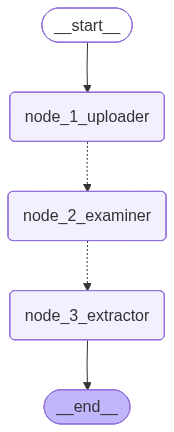

In [10]:
graph = StateGraph(OverallState)
graph.add_node("node_1_uploader", node_upload_and_organize)
graph.add_node("node_2_examiner", examine_single_csv_node) # the named node ("node_2_examiner") maps to the function examine_single_csv_node
graph.add_node("node_3_extractor", extract_single_csv_node) # the named node ("node_3_extractor") maps to the function extract_single_csv_node

graph.add_edge(START, "node_1_uploader")

graph.add_conditional_edges("node_1_uploader", examine_in_parallel_node, ["node_2_examiner"])   # Node 1 send the workflow to the examiner in parallel function, which then sends to the single examiners

graph.add_conditional_edges("node_2_examiner", extract_in_parallel_node, ["node_3_extractor"])

graph.add_edge("node_3_extractor", END)

# Compile the graph
Mine_this_mess = graph.compile()
Image(Mine_this_mess.get_graph().draw_mermaid_png())

## User inputs

In [11]:
input_file = 'Example_0.xlsx'
output_file = 'Example_0_output_consolidated.xlsx'

# If you want to have all sheets that are inside the Excel file to be consolidated into one cleaned up sheet
# then set this to True; otherwise, the system will treat the sheets separately
consolidate_sheets = True

In [12]:
# Optional (but very powerful): provide the agents with some context on the files / information is has to look for
# If you don't want to add any context here, just add as an empty str ""

# Uncomment for Example_0
user_context = "The file contains agricultural data that is almost correctly structured as I want, but it has empty rows; I need this to be a clean, contiguous table"

# Uncomment for Example_1
#user_context = """The file contains agricultural data for one experiment in cotton. The data is structure in a typical way from this kind of trial management software, 
#which is not very useful for further analysis. I need this to be a clean, contiguous table."""

# Uncomment for Example_2
#user_context = """The file contains technical and price data in German for a certain type of equipment. 
#The data is structure is almost OK, but not really clean. I need this to be a clean, contiguous table, with all names in English."""

In [13]:
# Prepare the initial state and run the graph
initial_state: OverallState = {"user_background": str(user_context), "file_name": input_file, "sheets_as_csv": {} , "consolidate_sheets": consolidate_sheets}
graph_result = Mine_this_mess.invoke(initial_state)

### Final step: assemble it back into an output "clean" Excel file

In [15]:
save_cleaned_data(graph_result, output_file)